In [1]:
# tensorflow=1.13
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

In [5]:
# prepare time series data
class TimeSeries():
    def __init__(self,x_min, x_max, num_points):
        self._x_min = x_min
        self._x_max = x_max
        self._interval = (x_max - x_min)/num_points
        self._x = np.linspace(self._x_min, self._x_max, num_points)
        self._y = np.sin(self._x)
        
    def next_batch(self, batch_size, steps):
        x_start = np.random.rand(batch_size,1)*(self._x_max - self._x_min - steps * self._interval) + self._x_min 
        x_batch = x_start + np.arange(0, steps+1) * self._interval
        y_batch = np.sin(x_batch)
        return x_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,:-1].reshape(-1, steps, 1)
    

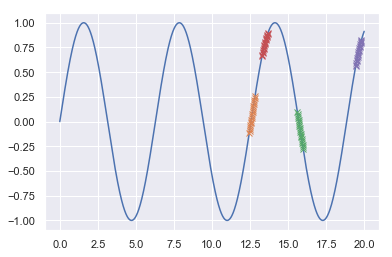

In [6]:
# generate data
ts = TimeSeries(0,20,1000)

# plot sine curve
sns.lineplot(x = ts._x, y=ts._y)

# plot batch overlay
for x,y in zip(*ts.next_batch(4,20)):
    plt.plot(x,y,"x")

In [7]:
class LSTM():
    def __init__(self, flags):
        
        # input
        self.input_x = tf.placeholder(tf.float32, shape=[flags["batch_size"], flags["step_size"], 1], name="input_x")
        self.input_y = tf.placeholder(tf.float32, shape=[flags["batch_size"], flags["step_size"], 1], name="input_y")
        
        # lstm
        self.cell = tf.keras.layers.LSTMCell(flags["units_size"])
        self.lstm = tf.keras.layers.RNN(self.cell,
                                  return_sequences = True,
                                  return_state = True,
                                  stateful = True)
        self.output, self.hidden_state, self.cell_state = self.lstm(self.input_x)
        
        # loss
        self.output_y = tf.keras.layers.Dense(1)(self.output)
        self.loss = tf.reduce_mean(tf.square(self.output_y - self.input_y))
        
        # optim
        self.optimizer = tf.train.AdamOptimizer(
                learning_rate=flags["learning_rate"]).minimize(self.loss)

In [8]:
class GRU():
    def __init__(self, flags):                
        # input
        self.input_x = tf.placeholder(tf.float32, shape=[flags["batch_size"], flags["step_size"], 1], name="input_x")
        self.input_y = tf.placeholder(tf.float32, shape=[flags["batch_size"], flags["step_size"], 1], name="input_y")
        
        # gru
        self.cell = tf.keras.layers.GRUCell(flags["units_size"])
        self.gru = tf.keras.layers.RNN(self.cell,
                                  return_sequences = True,
                                  return_state = True,
                                  stateful = True)
        self.output, _ = self.gru(self.input_x)
        
        # loss
        self.output_y = tf.keras.layers.Dense(1)(self.output)
        self.loss = tf.reduce_mean(tf.square(self.output_y - self.input_y))
        
        # optim
        self.optimizer = tf.train.AdamOptimizer(
                learning_rate=flags["learning_rate"]).minimize(self.loss)    

In [9]:
class DeepGRU():
    def __init__(self, flags):                
        # input
        self.input_x = tf.placeholder(tf.float32, shape=[flags["batch_size"], flags["step_size"], 1], name="input_x")
        self.input_y = tf.placeholder(tf.float32, shape=[flags["batch_size"], flags["step_size"], 1], name="input_y")
        
        # stack cells
        self.cells = [tf.keras.layers.GRUCell(flags["units_size"]) for _ in range(flags["num_layers"])]
        self.deep = tf.keras.layers.RNN(self.cells,
                                        return_sequences = True,
                                        return_state = True,
                                        stateful = True)
        self.output, *_ = self.deep(self.input_x)
        
        # loss
        self.output_y = tf.keras.layers.Dense(1)(self.output)
        self.loss = tf.reduce_mean(tf.square(self.output_y - self.input_y))
        
        # optim
        self.optimizer = tf.train.AdamOptimizer(
                learning_rate=flags["learning_rate"]).minimize(self.loss)    

In [10]:
FLAGS = {
    "num_epochs": 2000,
    "eval_per_epoch": 200,
    "learning_rate": 0.001,
  
    "batch_size": 32, # no. of examples
    "step_size": 20, # no. of steps along x axis
    
    "units_size": 100, # no. of hidden/cell state
    "num_layers":3, # for deep RNN
}

# model = LSTM(FLAGS)
# model = GRU(FLAGS)
model = DeepGRU(FLAGS)

init = tf.global_variables_initializer()

epoch 0 loss 0.53593475
epoch 200 loss 0.5250952
epoch 400 loss 0.109271094
epoch 600 loss 0.0651742
epoch 800 loss 0.048111476
epoch 1000 loss 0.05817285
epoch 1200 loss 0.028192054
epoch 1400 loss 0.0225696
epoch 1600 loss 0.026375497
epoch 1800 loss 0.017392993


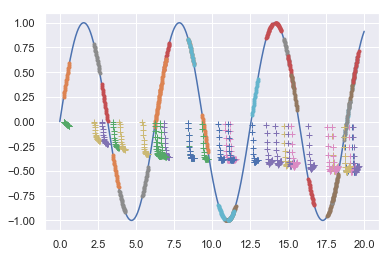

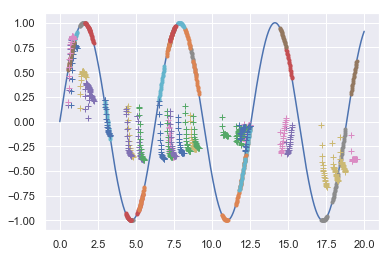

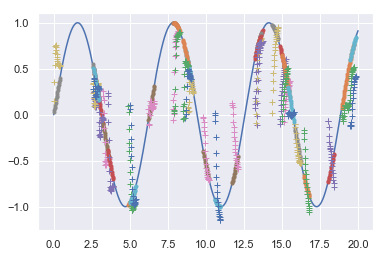

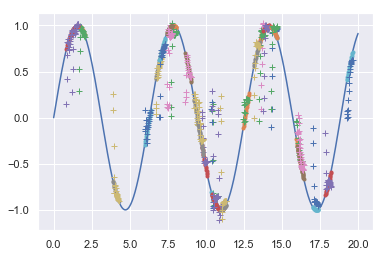

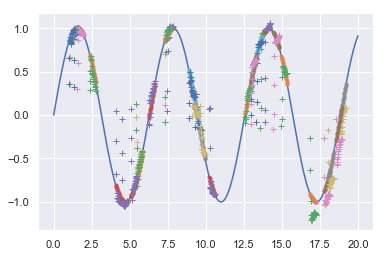

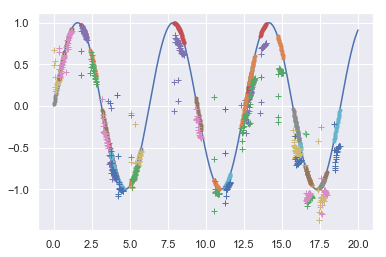

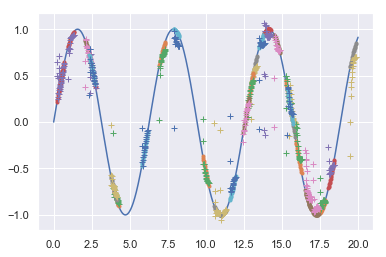

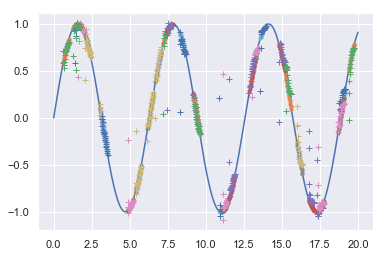

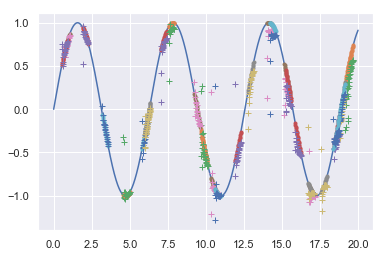

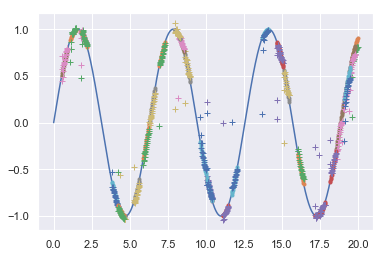

In [11]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(FLAGS["num_epochs"]):
        # generate a new set of batch
        x_batch, y_batch = ts.next_batch(FLAGS["batch_size"], FLAGS["step_size"])
        
        # train
        output_y,loss, _ = sess.run([model.output_y, model.loss, model.optimizer], feed_dict={
                model.input_x: x_batch,
                model.input_y: y_batch,
            })
        
        # eval
        if epoch % FLAGS["eval_per_epoch"] == 0:
            print("epoch", epoch, "loss", loss)
            
            # plot true y and output y
            plt.figure()
            sns.lineplot(x = ts._x, y = ts._y)
            for x,y,o in zip(x_batch[:,:,0], y_batch[:,:,0], output_y[:,:,0]):
                plt.plot(x,y,".")
                plt.plot(x,o,"+")